<a href="https://colab.research.google.com/github/escape13/deepfried/blob/master/IntroTorch/Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing the dataset

In [47]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from torchvision import datasets, transforms

In [48]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,), (0.5))])

In [49]:
trainset = datasets.FashionMNIST('F_MNIST_train/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('F_MNIST_test/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Neural network architecture

In [50]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.h1 = nn.Linear(784, 256)
        self.h2 = nn.Linear(256, 128)
        self.h3 = nn.Linear(128, 64)
        self.h4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = F.log_softmax(self.h4(x), dim=1)

        return x

## Training the network and storing validation data

In [51]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs = 30
training_loss = []
test_loss = []
train_size = len(trainloader)
test_size = len(testloader)

In [52]:
def train(model):
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            training_loss.append(running_loss / train_size)
            with torch.no_grad():
                model.eval()
                tmp = 0
                for images, labels in testloader:
                    output = model.forward(images)
                    tmp += criterion(output, labels).item()
                test_loss.append(tmp / test_size)
            model.train()

In [53]:
train(model)

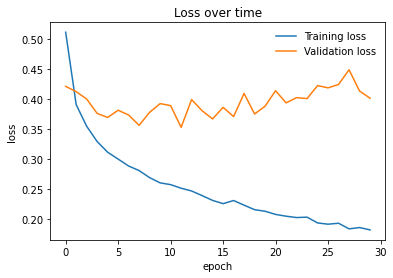

In [54]:
plt.plot(training_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.title('Loss over time')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.savefig('graph1.png', dpi=1200)

## Solving overfitting with the dropout technique

In [55]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.h1 = nn.Linear(784, 256)
        self.h2 = nn.Linear(256, 128)
        self.h3 = nn.Linear(128, 64)
        self.h4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.h1(x)))
        x = self.dropout(F.relu(self.h2(x)))
        x = self.dropout(F.relu(self.h3(x)))

        x = F.log_softmax(self.h4(x), dim=1)

        return x

In [56]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
training_loss = []
test_loss = []

In [57]:
train(model)

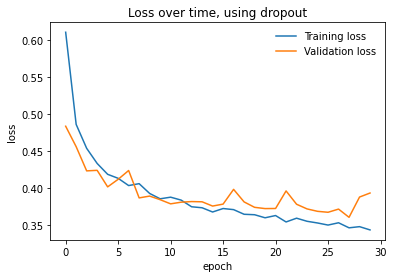

In [58]:
plt.plot(training_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.title('Loss over time, using dropout')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.savefig('graph2.png', dpi=1200)

## Saving training data

In [63]:
torch.save(model.state_dict(), 'checkpoint.pth')